In [1]:
!date

Thu Oct 22 17:38:03 PDT 2020


# No filter Smart-seq2 Gene comparison to 10x

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [3]:
adata = "../../data/SMARTseq/out_cr_index/annotated_adata.h5ad"
adata = anndata.read_h5ad(adata)
adata.var["gene_name"] = adata.var["gene_name"].astype(str) + "_" + adata.var.gene_id.astype(str)
adata.var["transcript_name"] = adata.var["transcript_name"].astype(str) + "_" + adata.var.transcript_id.astype(str)

In [4]:
def change(x):
    if x=="L5 ET": return "L5 PT"
    return x

In [5]:
adata.obs.subclass_label.value_counts()

L5 IT          1571
L6 CT           904
Vip             659
L6b             571
Pvalb           543
L2/3 IT         483
Sst             427
L6 IT           395
Lamp5           377
L5/6 NP         208
Sncg             84
SMC              21
L5 ET            12
Low Quality      12
Astro            10
Endo              7
VLMC              6
L6 IT Car3        5
Name: subclass_label, dtype: int64

In [6]:
adata.obs.cluster_label = adata.obs.cluster_label.apply(change).values
adata.obs.subclass_label = adata.obs.subclass_label.apply(change).values

In [7]:
adata.obs.subclass_label.value_counts()

L5 IT          1571
L6 CT           904
Vip             659
L6b             571
Pvalb           543
L2/3 IT         483
Sst             427
L6 IT           395
Lamp5           377
L5/6 NP         208
Sncg             84
SMC              21
L5 PT            12
Low Quality      12
Astro            10
Endo              7
VLMC              6
L6 IT Car3        5
Name: subclass_label, dtype: int64

In [8]:
lengths = pd.read_csv("../../reference/length_info.txt", header=None, names=["length", "transcript_id", "gene_id", "gene_name", "transcript_name", "chr", "start", "end", "strand"], sep="\t")
lengths["transcript_id"] = lengths["transcript_id"].apply(lambda x: x.split(".")[0])
lengths.index = lengths.transcript_id.values

In [9]:
adata.var["length"] = adata.var.transcript_id.map(lengths["length"])

In [10]:
adata.var.head()

,transcript_id,gene_id,gene_name,transcript_name,length
0,ENSMUST00000162897,ENSMUSG00000051951,Xkr4_ENSMUSG00000051951,Xkr4-203_ENSMUST00000162897,4153
1,ENSMUST00000159265,ENSMUSG00000051951,Xkr4_ENSMUSG00000051951,Xkr4-202_ENSMUST00000159265,2989
2,ENSMUST00000070533,ENSMUSG00000051951,Xkr4_ENSMUSG00000051951,Xkr4-201_ENSMUST00000070533,3634
3,ENSMUST00000161581,ENSMUSG00000089699,Gm1992_ENSMUSG00000089699,Gm1992-201_ENSMUST00000161581,250
4,ENSMUST00000194643,ENSMUSG00000102343,Gm37381_ENSMUSG00000102343,Gm37381-202_ENSMUST00000194643,657


In [11]:
# l = lil_matrix((adata.var["length"].shape[0], adata.var["length"].shape[0]))
# l.setdiag(1/adata.var["length"])

In [12]:
# scaled = adata.X*l

In [13]:
raw = adata.X.todense()

In [14]:
scaled = raw/adata.var.length.values

In [15]:
a = np.matrix([[1, 2],[0,1],[2, 1],[1,1]])
b = np.array([5,1])

In [16]:
print(a)
print(a/b)

[[1 2]
 [0 1]
 [2 1]
 [1 1]]
[[0.2 2. ]
 [0.  1. ]
 [0.4 1. ]
 [0.2 1. ]]


In [17]:
adata.layers["X"] = csr_matrix(scaled)
adata.X = csr_matrix(scaled)

In [18]:
adata.layers["norm"] = normalize(adata.X, norm='l1', axis=1)*1000000

In [19]:
adata.layers["norm"][0].sum()

1000000.0000000042

In [20]:
adata.layers["log1p"] = np.log1p(adata.layers["norm"])

In [21]:
adata.layers["norm"][0].sum()

1000000.0000000042

In [22]:
adata.X = adata.layers["norm"]

In [23]:
adata.layers["norm"][0].sum()

1000000.0000000042

In [24]:
adata.layers["norm"][0].sum()

1000000.0000000042

In [25]:
del raw
del scaled

In [26]:
adata.layers["norm"][0].sum()

1000000.0000000042

In [27]:
def group_mtx(mtx, components, features, s2t, source_id="transcript_id", target_id="gene_id", by="features"):
    """
    mtx: ndarray components by features 
    components: labels for rows of mtx
    features: labels for columns of mtx
    s2t: pandas dataframe mapping source (features or components) to a
    targets features(components) to group by
    target_id: column name in s2t to group by
    """
    if target_id not in s2t.columns: return -1
    
    ncomp   = components.shape[0]
    nfeat   = features.shape[0]
    ntarget = s2t[target_id].nunique()
    
    if by =="features": 
        source = features
    elif by =="components": 
        source = components
    
    # Map the source to an index
    source2idx = dict(zip(source, range(len(source))))
    # Map the target to a list of source indices
    target2idx = (s2t.groupby(target_id)[source_id].apply(lambda x: [source2idx[i] for i in x])).to_dict()
    
    # array of unique targets
    unique = s2t[target_id].unique().astype(str)
    nuniq = unique.shape[0]
    X = np.zeros((ncomp, nuniq))
    
    for tidx, t in enumerate(unique):
        # Grab the matrix indices corresponding to columns and source columns to group by
        source_indices = target2idx[t]
        
        # breaks generality
        sub_mtx = mtx[:, source_indices].sum(axis=1) # Sum on source indicies
        X[:,tidx] = np.asarray(sub_mtx)[:,0] # place summed vector in new matrix
        
    # Return matrix that is grouped by
    return (X, components, unique)
    
def filter_mtx(mtx, components, features, **kwargs):
    row_counts = kwargs.get("row_counts", 0) # threshold for min counts for rows
    col_counts = kwargs.get("col_counts", 0)
    row_zeros  = kwargs.get("row_zeros", 0) # threshold min number of non_zero entries in rows
    col_zeros  = kwargs.get("col_zeros", 0)
    
    return_mask = kwargs.get("return_mask", False)
    
    row_sum = np.asarray(mtx.sum(axis=1)).reshape(-1) # sum along the rows
    col_sum = np.asarray(mtx.sum(axis=0)).reshape(-1)
    
    mtx_zero_mask = mtx>0
    row_nz = np.asarray(mtx_zero_mask.sum(axis=1)).reshape(-1)
    col_nz = np.asarray(mtx_zero_mask.sum(axis=0)).reshape(-1)
    
    # Generate masks
    rs_mask = row_sum > row_counts
    cs_mask = col_sum > col_counts
    
    rz_mask = row_nz > row_zeros
    cz_mask = col_nz > col_zeros
    
    row_mask = np.logical_and(rs_mask, rz_mask)
    col_mask = np.logical_and(cs_mask, cz_mask)
    
    if return_mask:
        return (row_mask, col_mask)
    
    X = mtx[row_mask,:][:,col_mask]
    c = components[row_mask]
    f = features[col_mask]
    
    return (X, c, f)

In [28]:
%%time

mtx = np.array([[1,1,0],
                [0,1,0],
                [3,0,0],
                [0,2,0]])

components = np.array([1,2,3,4])
features = np.array([1, 2, 3])

X, c, f = filter_mtx(mtx, components, features, row_zeros=1, col_zeros=3)
rm, cmask = filter_mtx(mtx, components, features, return_mask=True)

CPU times: user 158 µs, sys: 55 µs, total: 213 µs
Wall time: 216 µs


In [29]:
cmask

array([ True,  True, False])

In [30]:
X

array([], shape=(1, 0), dtype=int64)

In [31]:
X==mtx

False

# Group isoforms into genes, and filter. 

go back and filter on isoforms and apply it to genes

In [32]:
%%time

mtx        = adata.layers["X"]
components = adata.obs.cell_id.values
features   = adata.var.transcript_id.values


rm, cmask = filter_mtx(mtx, components, features, col_counts=1, col_zeros=1, return_mask=True)

CPU times: user 1.37 s, sys: 600 ms, total: 1.97 s
Wall time: 1.97 s


In [33]:
cmask.sum()

69360

In [34]:
adata = adata#[:,cmask]

mtx        = adata.layers["X"]
components = adata.obs.cell_id.values
features   = adata.var.transcript_id.values

In [35]:
adata

AnnData object with n_obs × n_vars = 6295 × 111079
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'
    layers: 'X', 'norm', 'log1p'

In [36]:
%%time

mtx        = adata.layers["X"].todense()
components = adata.obs.cell_id.values
features   = adata.var.transcript_id.values

source_id = "transcript_id"
target_id = "gene_id"


s2t = adata.var

# Data for gene matrix
X, c, f = group_mtx(mtx, components, features, s2t)

CPU times: user 25.1 s, sys: 4.48 s, total: 29.6 s
Wall time: 29.6 s


In [37]:
adata

AnnData object with n_obs × n_vars = 6295 × 111079
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'
    layers: 'X', 'norm', 'log1p'

In [38]:
# generate isoform based on gene mask.
isoform = adata[:, adata.var.gene_id.isin(f)]

In [39]:
# generate gene
tmp = adata.var.drop_duplicates(["gene_id", "gene_name"])
tmp = tmp[tmp.gene_id.isin(f)]
gene = anndata.AnnData(X=X, obs=adata.obs, var=tmp)

In [40]:
print(isoform)
print(gene)

View of AnnData object with n_obs × n_vars = 6295 × 111079
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'
    layers: 'X', 'norm', 'log1p'
AnnData object with n_obs × n_vars = 6295 × 31053
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'


In [41]:
gene.var.index = gene.var.gene_name.values
isoform.var.index = isoform.var.transcript_name.values

# Begin Check

In [42]:
# the gene_id is OK, need to fix the gene name to reflected the fact that
# the same gene_name is used with multiple gene_ids

In [43]:
adata.var.gene_id.nunique() == gene.var.gene_name.nunique()

True

In [44]:
adata.var.transcript_id.nunique() == isoform.var.transcript_name.nunique()

True

In [45]:
gene.X = csr_matrix(gene.X)

In [46]:
gene.layers["X"] = gene.X.copy() # here, X is rho, the number of molecules
isoform.layers["X"] = isoform.X.copy() # here X is rho, the number of molecules

# Perform matrix operations

In [47]:
num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 50
num_NCA = 10

# Filtering criteria
cell_threshold = 250
disp_threshold = 0.001

mito_criteria = 10

n_top_genes = 5000

n_bins = 20

flavor="seurat"

scale_clip = 10

### Adding info to rows/cols

In [48]:
# turning subclass_label into an id
le = LabelEncoder()
gene.obs["subclass_id"] = le.fit_transform(gene.obs.subclass_label.values)
isoform.obs["subclass_id"] = le.fit_transform(isoform.obs.subclass_label.values)

In [49]:
# turning class_label into an id
le = LabelEncoder()
gene.obs["class_id"] = le.fit_transform(gene.obs.class_label.values)
isoform.obs["class_id"] = le.fit_transform(isoform.obs.class_label.values)

In [50]:
gene.var["gene_id"] = gene.var["gene_id"].astype(str)

In [51]:
# Adding list and number of isoforms to each gene
g2t = isoform.var.groupby("gene_id")["transcript_id"].apply(list)
gene.var["txn_list"] = gene.var["gene_id"].map(g2t)
num_iso = g2t.apply(lambda x: len(x))
gene.var["num_isoforms"] = gene.var["gene_id"].map(num_iso).astype(int)

In [52]:
# Writing cell_TPM, gene_TPM, n_genes, and percent_mito for each cell
gene.obs["cell_counts"] = gene.X.sum(1)
gene.var["gene_counts"] = np.asarray(gene.X.sum(0)).reshape(-1)

isoform.obs["cell_counts"] = isoform.X.sum(1)
isoform.var["gene_counts"] = np.asarray(isoform.X.sum(0)).reshape(-1)

mito_genes = gene.var_names.str.startswith('mt-')
gene.obs["percent_mito"] = gene[:,mito_genes].X.sum(axis=1)/gene.X.sum(axis=1)*100
gene.obs["n_genes"] = (gene.X>0).sum(axis=1)

In [53]:
# For each gene, compute the dispersion and store it
mtx = gene.X.todense()
mean = np.asarray(mtx.mean(axis=0)).reshape(-1)
var = np.asarray(np.power(mtx, 2).mean(axis=0)).reshape(-1) - mean**2

dispersion = var / mean

In [54]:
gene.var["dispersion"] = dispersion
gene.var["pass_disp_filter"] = gene.var["dispersion"] > disp_threshold

In [55]:
gene.var["pass_disp_filter"].sum()

27020

In [56]:
gene.obs["pass_count_filter"] = gene.obs["cell_counts"] > cell_threshold

In [57]:
gene.obs["pass_count_filter"].sum()

6175

### Filtering

In [58]:
gene.shape

(6295, 31053)

In [59]:
isoform.shape

(6295, 111079)

In [60]:
# l = gene.var.txn_list[gene.var.pass_disp_filter].values
# flat_list = [item for sublist in l for item in sublist]

In [61]:
# gene_disp_mask = gene.var["pass_disp_filter"].values
# gene_cell_mask = gene.obs["pass_count_filter"].values
# 
# iso_disp_mask = isoform.var["transcript_id"].isin(flat_list)
# iso_cell_mask = gene.obs["pass_count_filter"].values

In [62]:
# print(gene_cell_mask.sum(), gene_disp_mask.sum())
# print(iso_cell_mask.sum(), iso_disp_mask.sum())

In [63]:
# gene = gene[gene_cell_mask, gene_disp_mask]
# isoform = isoform[iso_cell_mask, iso_disp_mask]

In [64]:
print(isoform.shape)
print(gene.shape)

(6295, 111079)
(6295, 31053)


In [65]:
#mito_mask = (gene.obs.percent_mito < mito_criteria).values

In [66]:
# mito_mask.sum()

In [67]:
# gene = gene[mito_mask,:]
# isoform = isoform[mito_mask,:]

In [68]:
print(gene.shape)
print(isoform.shape)

(6295, 31053)
(6295, 111079)


### Adding info to matrices

In [69]:
gene.layers["norm"] = normalize(gene.X, norm='l1', axis=1)*1000000
isoform.layers["norm"] = normalize(isoform.X, norm='l1', axis=1)*1000000

In [70]:
gene.layers["log1p"] = np.log1p(gene.layers["norm"])
isoform.layers["log1p"] = np.log1p(isoform.layers["norm"])

In [71]:
gene.X = gene.layers["log1p"]
isoform.X = isoform.layers["log1p"]

In [72]:
tmp = gene.copy()

In [73]:
scanp.pp.log1p(tmp)

In [74]:
d = tmp.uns

In [75]:
gene.uns = d
isoform.uns = d

### Highly Variable Genes

In [76]:
scanp.pp.highly_variable_genes(gene, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = gene.var.highly_variable.values

In [77]:
scanp.pp.highly_variable_genes(isoform, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvi_mask = isoform.var.highly_variable.values

### Scaling data to unit variance, zero mean for clustering

In [78]:
from sklearn.preprocessing import scale

In [79]:
%%time
mat = gene.layers["log1p"].todense()
mtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
gene.X = mtx

CPU times: user 5.83 s, sys: 3.32 s, total: 9.15 s
Wall time: 9.15 s


In [80]:
%%time
mat = isoform.layers["log1p"].todense()
mtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
isoform.X = mtx

CPU times: user 20.7 s, sys: 13.2 s, total: 33.9 s
Wall time: 33.9 s


In [81]:
print(gene)
print(isoform)

AnnData object with n_obs × n_vars = 6295 × 31053
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'X', 'norm', 'log1p'
AnnData object with n_obs × n_vars = 6295 × 111079
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'X', 'norm', 'log1p'


In [82]:
gene.write("../../data/notebook/revision/no_filter_gene.h5ad")
isoform.write("../../data/notebook/revision/no_filter_isoform.h5ad")

... storing 'gene_name' as categorical


In [83]:
ss=gene

# Perform comparison

In [106]:
#ss = anndata.read_h5ad("../cell_ranger_annotation/no_filter_gene.h5ad")

In [85]:
t_adata = anndata.read_h5ad("../../data/notebook/revision/10xv3_gene.h5ad")

In [86]:
tenx = t_adata[:,t_adata.var.index.isin(ss.var.index)]

In [87]:
tenx = tenx[:,tenx.var.sort_index().index]

In [88]:
from sklearn.preprocessing import normalize

In [89]:
tenx.layers["X"] = tenx.X
tenx.layers["norm"] = normalize(tenx.X, norm='l1', axis=1)*1000000
tenx.layers["log1p"] = csr_matrix(np.log1p(tenx.layers["norm"]))

In [90]:
tenx.obs.subclass_label.value_counts()

L5 IT          29721
Low Quality    22728
L6 CT          12807
L2/3 IT        10915
L6 IT           4445
L5/6 NP         3147
Vip             2966
Lamp5           2357
Sst             1869
L6b              554
Oligo            535
Astro            395
Pvalb            368
Sncg             348
doublet          257
Endo             187
L5 PT            161
OPC              145
Macrophage       122
L6 IT Car3        69
VLMC              55
SMC               11
Name: subclass_label, dtype: int64

In [91]:
from sklearn.preprocessing import scale

In [92]:
%%time
mat = tenx.layers["log1p"].todense()
mtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
tenx.X = mtx

CPU times: user 1min 31s, sys: 1min 35s, total: 3min 6s
Wall time: 3min 7s


In [93]:
ss = ss[:,ss.var.sort_index().index]

In [94]:
del mat
del mtx

In [95]:
def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def group_mtx_by_cluster(mtx, components, features, s2t, source_id="cell_id", target_id="subclass_label", by="components"):
    """
    mtx: ndarray components by features 
    components: labels for rows of mtx
    features: labels for columns of mtx
    s2t: pandas dataframe mapping source (features or components) to a
    targets features(components) to group by
    target_id: column name in s2t to group by
    """
    if target_id not in s2t.columns: return -1
    
    ncomp   = components.shape[0]
    nfeat   = features.shape[0]
    ntarget = s2t[target_id].nunique()
    
    if by =="features": 
        source = features
    elif by =="components": 
        source = components
    
    # Map the source to an index
    source2idx = dict(zip(source, range(len(source))))
    # Map the target to a list of source indices
    target2idx = (s2t.groupby(target_id)[source_id].apply(lambda x: [source2idx[i] for i in x])).to_dict()
    
    # array of unique targets
    unique = s2t[target_id].unique().astype(str)
    nuniq = unique.shape[0]
    X = np.zeros((nuniq, mtx.shape[1]))
    
    for tidx, t in enumerate(unique):
        # Grab the matrix indices corresponding to columns and source columns to group by
        source_indices = target2idx[t]
        #print(source_indices)
        
        # breaks generality
        sub_mtx = mtx[source_indices,:].mean(axis=0) # Sum on source indicies
        X[tidx,:] = sub_mtx # place summed vector in new matrix
        
    # Return matrix that is grouped by
    return (X, components, unique)

In [96]:
tenx_mat = tenx.X
tenx_ass = tenx.obs.subclass_label.values

In [97]:
ss_mat = ss.X
ss_ass = ss.obs.subclass_label.values

In [98]:
features = tenx.var.gene_name.values

unique = np.intersect1d(np.unique(tenx_ass), np.unique(ss_ass))

In [99]:
def nd(arr):
    return np.asarray(arr).reshape(-1)

In [100]:
mat = tenx.layers["log1p"]

lower = 0.5


bool_mask = np.zeros((unique.shape[0], features.shape[0]), dtype=bool)

for uidx, u in enumerate(unique):
    t_mat, _ = split_by_target(mat, tenx_ass, u)

    numc = t_mat.shape[0]
    numnz = (t_mat>0).sum(axis=0)

    #arr = np.logical_and(nd(numnz>lower*numc), nd(numnz<upper*numc))
    arr = nd(numnz>lower*numc)
    
    #arr = np.logical_and(np.array(t_mat.mean(axis=0)>threshold).reshape(-1), (np.array((t_mat>0).sum(axis=0)>t_mat.shape[0]*frac).reshape(-1)))
    print("[{} of {}] {:,}: {}".format(uidx+1, unique.shape[0],arr.sum(), u) )
    
    #argnmax = arr.argsort()[-n:][::-1]

    bool_mask[uidx,:][arr] = True

[1 of 18] 711: Astro
[2 of 18] 940: Endo
[3 of 18] 6,878: L2/3 IT
[4 of 18] 6,105: L5 IT
[5 of 18] 5,536: L5 PT
[6 of 18] 5,250: L5/6 NP
[7 of 18] 6,294: L6 CT
[8 of 18] 6,940: L6 IT
[9 of 18] 6,480: L6 IT Car3
[10 of 18] 6,550: L6b
[11 of 18] 5,900: Lamp5
[12 of 18] 1,443: Low Quality
[13 of 18] 6,948: Pvalb
[14 of 18] 1,294: SMC
[15 of 18] 6,432: Sncg
[16 of 18] 6,455: Sst
[17 of 18] 540: VLMC
[18 of 18] 4,111: Vip


In [101]:
from scipy import stats

In [102]:
%%time
r2 = []
ss_x = []
tenx_x = []

# u_mat_tenx = []
# u_mat_ss   = []

for uidx, u in enumerate(unique):
    tenx_t_mat, _ = split_by_target(tenx_mat, tenx_ass, u)
    ss_t_mat, _ = split_by_target(ss_mat, ss_ass, u)
    
    # u_mat_tenx.append(tenx_t_mat)
    # u_mat_ss.append(ss_t_mat)
    
    
    t = np.asarray(tenx_t_mat[:,bool_mask[uidx]].mean(axis=0)).reshape(-1)
    s = np.asarray(ss_t_mat[:,bool_mask[uidx]].mean(axis=0)).reshape(-1)
    
    ss_x.append(s)
    tenx_x.append(t)
    
    r, p = stats.pearsonr(t, s)
    r2.append(r)
    print("[{} of {}] {:,.2f}: {}".format(uidx+1, unique.shape[0],r, u) )

[1 of 18] 0.84: Astro
[2 of 18] 0.89: Endo
[3 of 18] 0.72: L2/3 IT
[4 of 18] 0.58: L5 IT
[5 of 18] 0.65: L5 PT
[6 of 18] 0.82: L5/6 NP
[7 of 18] 0.76: L6 CT
[8 of 18] 0.73: L6 IT
[9 of 18] 0.66: L6 IT Car3
[10 of 18] 0.79: L6b
[11 of 18] 0.88: Lamp5
[12 of 18] -0.48: Low Quality
[13 of 18] 0.85: Pvalb
[14 of 18] 0.77: SMC
[15 of 18] 0.85: Sncg
[16 of 18] 0.88: Sst
[17 of 18] 0.51: VLMC
[18 of 18] 0.84: Vip
CPU times: user 1min 9s, sys: 1min 40s, total: 2min 50s
Wall time: 2min 44s


In [103]:
ss_size = ss.obs["subclass_label"].value_counts()[unique]

In [104]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

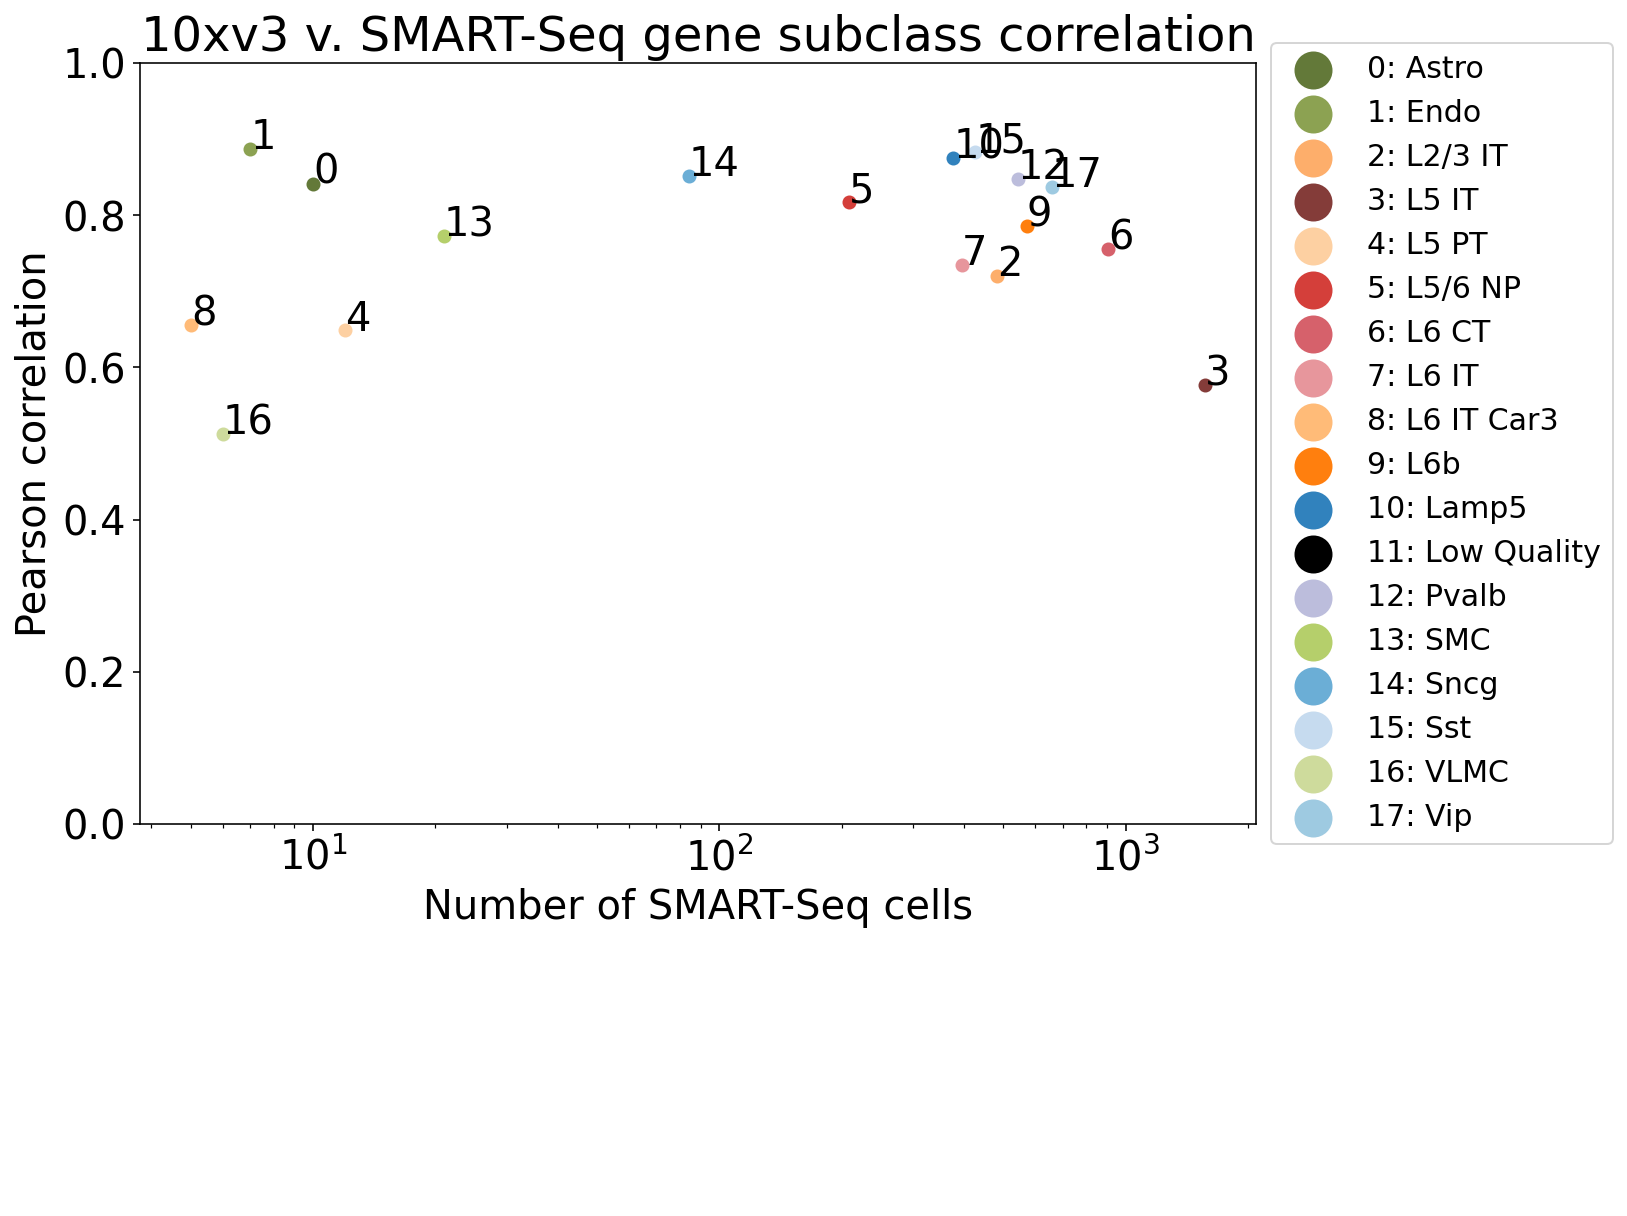

In [105]:
fig, ax = plt.subplots(figsize=(10,7))

x = ss_size
y = r2

for i, txt in enumerate(unique):
    ax.annotate(i, (x[i], y[i]))
    ax.scatter(x[i], y[i], label="{}: {}".format(i, txt), color=cluster_cmap[txt])
ax.set_ylim((0, 1))
ax.set_xscale("log")
    
ax.set_xlabel("Number of SMART-Seq cells")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
ax.set_title("10xv3 v. SMART-Seq gene subclass correlation")

plt.savefig("../../figures/10x_gene_subclass_correlation_size.png", bbox_inches='tight', dpi=300)
plt.show()

In [106]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

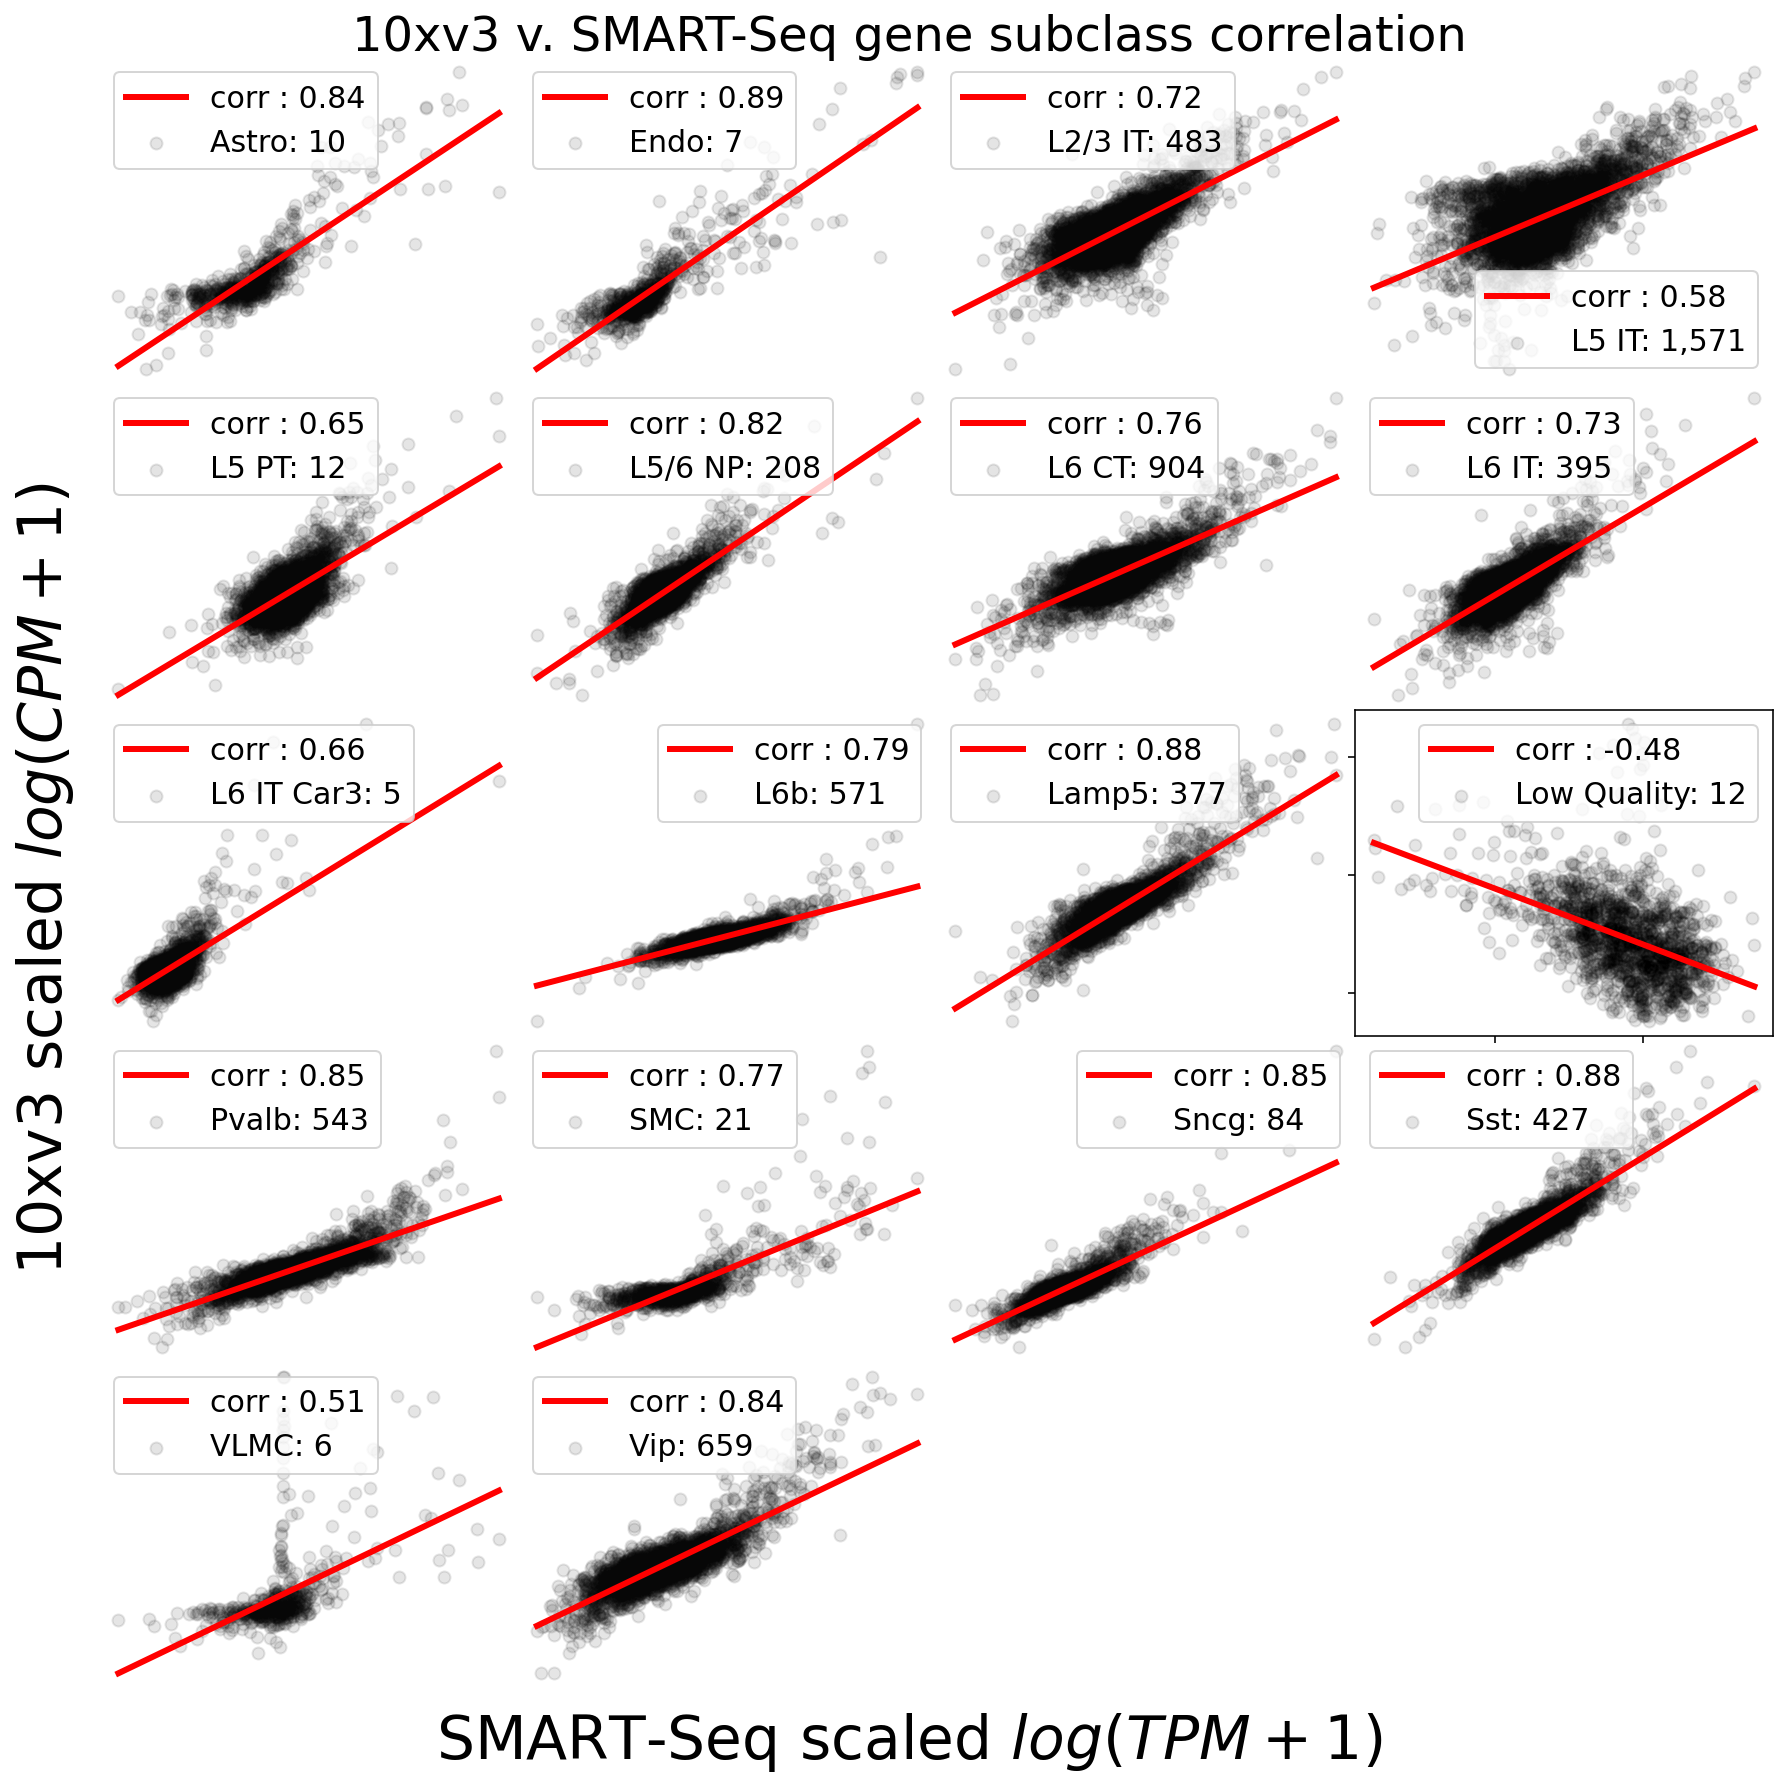

In [107]:
fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=5)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, len(unique))
fig.suptitle('10xv3 v. SMART-Seq gene subclass correlation', y=0.9)

for cidx, (ax, c) in enumerate(zip(axs, unique)):
    
    
    x = ss_x[cidx]
    y = tenx_x[cidx]

    
    ax.scatter(x, y, label="{}: {:,}".format(c, ss_size[cidx]), color="k", alpha=0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    minx = min(x)
    maxx = max(x)
    x = np.linspace(minx, maxx, 10)
    y = slope*x+intercept
    ax.plot(x, y, label="corr : {:,.2f}".format(r_value), color="red", linewidth=3)
    ax.legend(fontsize=15)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()
    if c == "Low Quality":
        ax.set_axis_on()
fig.text(0.5, 0.1, 'SMART-Seq scaled $log(TPM+1)$', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, '10xv3 scaled $log(CPM+1)$', ha='center', va='center', rotation='vertical', fontsize=30)
plt.savefig("../../figures/10x_gene_subclass_correlation_scatter.png", bbox_inches='tight',dpi=300)

plt.show()

# At the cluster level

In [108]:
tenx = tenx[:,tenx.var.sort_index().index]
ss = ss[:,ss.var.sort_index().index]

In [109]:
tenx_mat = tenx.X
tenx_ass = tenx.obs.cluster_label.values

In [110]:
ss_mat = ss.X
ss_ass = ss.obs.cluster_label.values

In [111]:
features = tenx.var.gene_name.values

unique = np.intersect1d(np.unique(tenx_ass), np.unique(ss_ass))

In [112]:
def nd(arr):
    return np.asarray(arr).reshape(-1)

In [113]:
mat = tenx.layers["log1p"]

lower = 0.5


bool_mask = np.zeros((unique.shape[0], features.shape[0]), dtype=bool)

for uidx, u in enumerate(unique):
    t_mat, _ = split_by_target(mat, tenx_ass, u)

    numc = t_mat.shape[0]
    numnz = (t_mat>0).sum(axis=0)

    #arr = np.logical_and(nd(numnz>lower*numc), nd(numnz<upper*numc))
    arr = nd(numnz>lower*numc)
    
    #arr = np.logical_and(np.array(t_mat.mean(axis=0)>threshold).reshape(-1), (np.array((t_mat>0).sum(axis=0)>t_mat.shape[0]*frac).reshape(-1)))
    print("[{} of {}] {:,}: {}".format(uidx+1, unique.shape[0],arr.sum(), u) )
    
    #argnmax = arr.argsort()[-n:][::-1]

    bool_mask[uidx,:][arr] = True

[1 of 22] 711: Astro Aqp4
[2 of 22] 6,859: L5 IT Pld5
[3 of 22] 6,764: L5 IT Tcap_1
[4 of 22] 5,478: L5 IT Tcap_2
[5 of 22] 6,068: L6 CT Gpr139
[6 of 22] 6,480: L6 IT Car3
[7 of 22] 6,865: L6b Rprm
[8 of 22] 6,193: L6b Shisa6
[9 of 22] 5,393: Lamp5 Lhx6
[10 of 22] 7,594: Pvalb Calb1
[11 of 22] 6,827: Pvalb Reln
[12 of 22] 6,670: Pvalb Vipr2
[13 of 22] 6,286: Sst Chodl
[14 of 22] 7,338: Sst Crhr2_1
[15 of 22] 7,169: Sst Crhr2_2
[16 of 22] 5,458: Sst Myh8_1
[17 of 22] 5,879: Sst Myh8_2
[18 of 22] 4,326: Vip C1ql1
[19 of 22] 3,784: Vip Crispld2
[20 of 22] 4,917: Vip Gpc3
[21 of 22] 3,528: Vip Igfbp6
[22 of 22] 4,275: Vip Serpinf1


In [114]:
%%time
r2 = []
ss_x = []
tenx_x = []

# u_mat_tenx = []
# u_mat_ss   = []

for uidx, u in enumerate(unique):
    tenx_t_mat, _ = split_by_target(tenx_mat, tenx_ass, u)
    ss_t_mat, _ = split_by_target(ss_mat, ss_ass, u)
    
    # u_mat_tenx.append(tenx_t_mat)
    # u_mat_ss.append(ss_t_mat)
    
    
    t = np.asarray(tenx_t_mat[:,bool_mask[uidx]].mean(axis=0)).reshape(-1)
    s = np.asarray(ss_t_mat[:,bool_mask[uidx]].mean(axis=0)).reshape(-1)
    
    ss_x.append(s)
    tenx_x.append(t)
    
    r, p = stats.pearsonr(t, s)
    r2.append(r)
    print("[{} of {}] {:,.2f}: {}".format(uidx+1, unique.shape[0],r, u) )

[1 of 22] 0.84: Astro Aqp4
[2 of 22] 0.35: L5 IT Pld5
[3 of 22] 0.56: L5 IT Tcap_1
[4 of 22] 0.44: L5 IT Tcap_2
[5 of 22] 0.76: L6 CT Gpr139
[6 of 22] 0.66: L6 IT Car3
[7 of 22] 0.67: L6b Rprm
[8 of 22] 0.71: L6b Shisa6
[9 of 22] 0.75: Lamp5 Lhx6
[10 of 22] 0.81: Pvalb Calb1
[11 of 22] 0.84: Pvalb Reln
[12 of 22] 0.77: Pvalb Vipr2
[13 of 22] 0.83: Sst Chodl
[14 of 22] 0.76: Sst Crhr2_1
[15 of 22] 0.75: Sst Crhr2_2
[16 of 22] 0.85: Sst Myh8_1
[17 of 22] 0.83: Sst Myh8_2
[18 of 22] 0.81: Vip C1ql1
[19 of 22] 0.85: Vip Crispld2
[20 of 22] 0.80: Vip Gpc3
[21 of 22] 0.80: Vip Igfbp6
[22 of 22] 0.68: Vip Serpinf1
CPU times: user 7min 8s, sys: 2min 43s, total: 9min 52s
Wall time: 9min 43s


In [121]:
ss_size = ss.obs["cluster_label"].value_counts()[unique]

In [122]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [123]:
unique

array(['Astro Aqp4', 'L5 IT Pld5', 'L5 IT Tcap_1', 'L5 IT Tcap_2',
       'L6 CT Gpr139', 'L6 IT Car3', 'L6b Rprm', 'L6b Shisa6',
       'Lamp5 Lhx6', 'Pvalb Calb1', 'Pvalb Reln', 'Pvalb Vipr2',
       'Sst Chodl', 'Sst Crhr2_1', 'Sst Crhr2_2', 'Sst Myh8_1',
       'Sst Myh8_2', 'Vip C1ql1', 'Vip Crispld2', 'Vip Gpc3',
       'Vip Igfbp6', 'Vip Serpinf1'], dtype=object)

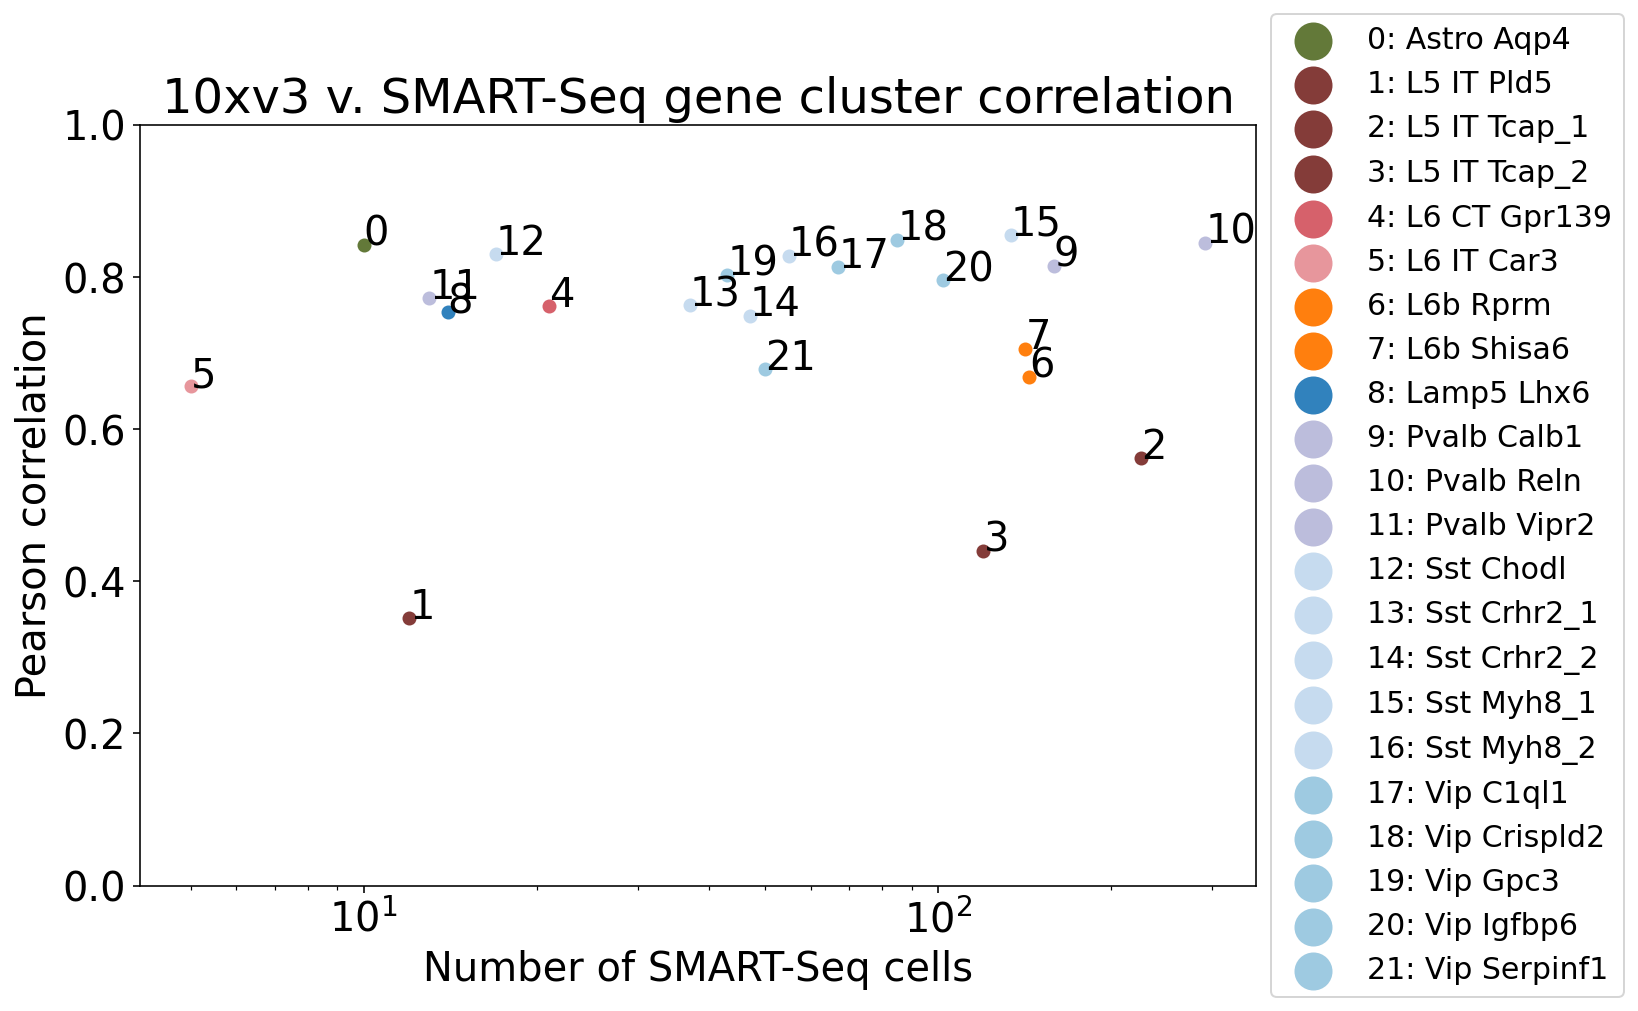

In [124]:
fig, ax = plt.subplots(figsize=(10,7))

x = ss_size
y = r2

for i, txt in enumerate(unique):
    ax.annotate(i, (x[i], y[i]))
    ax.scatter(x[i], y[i], label="{}: {}".format(i, txt), color=cluster_cmap[" ".join(txt.split(" ")[0:-1])])
ax.set_ylim((0, 1))
ax.set_xscale("log")
ax.set_title("10xv3 v. SMART-Seq gene cluster correlation")

ax.set_xlabel("Number of SMART-Seq cells")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
plt.savefig("../../figures/10x_gene_cluster_correlation.png", bbox_inches='tight', dpi=300)
plt.show()

In [125]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

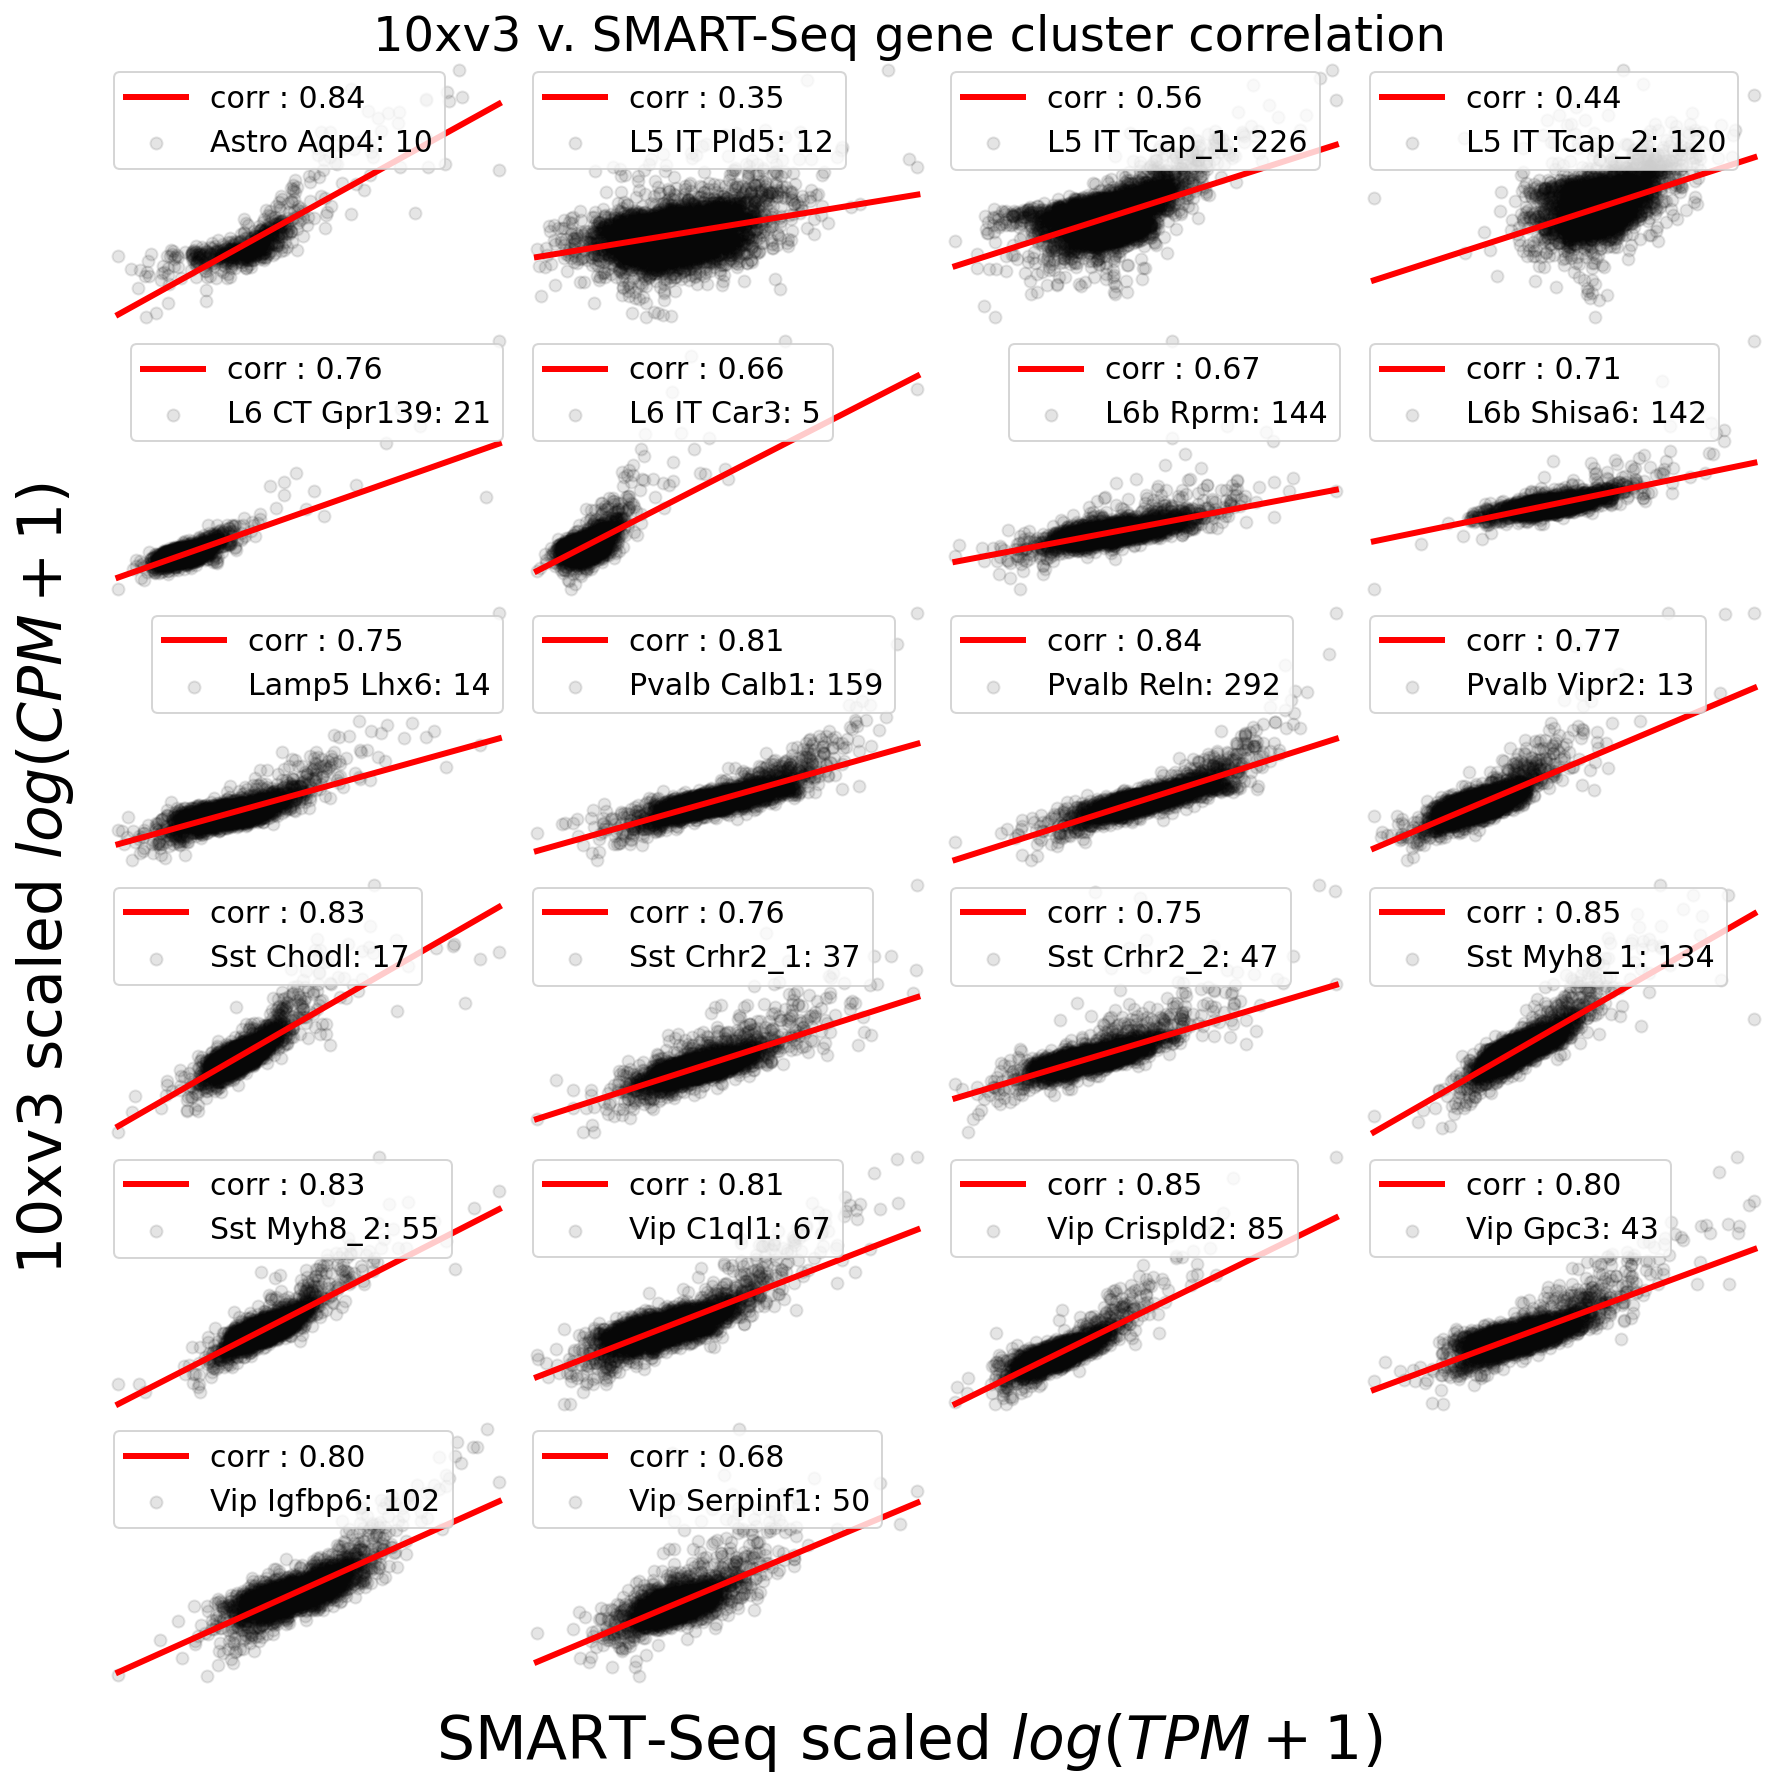

In [126]:
fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=6)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, len(unique))

fig.suptitle('10xv3 v. SMART-Seq gene cluster correlation', y=0.9)


for cidx, (ax, c) in enumerate(zip(axs, unique)):
    
    
    x = ss_x[cidx]
    y = tenx_x[cidx]

    
    ax.scatter(x, y, label="{}: {:,}".format(c, ss_size[cidx]), color="k", alpha=0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    minx = min(x)
    maxx = max(x)
    x = np.linspace(minx, maxx, 10)
    y = slope*x+intercept
    ax.plot(x, y, label="corr : {:,.2f}".format(r_value), color="red", linewidth=3)
    ax.legend(fontsize=15)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()
    if c == "Low Quality":
        ax.set_axis_on()
fig.text(0.5, 0.1, 'SMART-Seq scaled $log(TPM+1)$', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, '10xv3 scaled $log(CPM+1)$', ha='center', va='center', rotation='vertical', fontsize=30)
plt.savefig("../../figures/10x_gene_cluster_correlation_scatter.png", bbox_inches='tight',dpi=300)

plt.show()
